# Implementation of Wasserstein GAN on Celeba dataset - V1

This notebook illustrates that the way to create simple WGAN architecture. Implementation is influenced from the assignments given in the [GAN specialization on Coursera](https://www.coursera.org/specializations/generative-adversarial-networks-gans?)

* WANDB project name : 'test1: without_init_weights'
* WANDB project link : https://wandb.ai/hobby_projects/WGAN_implementation?workspace=user-hobby_projects
* training was done on subset of the dataset

In [ ]:
import torch
import numpy as np
from torch import nn
from torchsummary import summary
import torchvision
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

##1. Download the Dataset (CelebA)

In [ ]:
import zipfile
import os
if not os.path.isfile('celeba.zip'):
  !mkdir data_faces && wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip 
  with zipfile.ZipFile("celeba.zip","r") as zip_ref:
    zip_ref.extractall("data_faces/")

--2021-01-19 12:05:16--  https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.116.96
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.116.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1443490838 (1.3G) [application/zip]
Saving to: ‘celeba.zip’

celeba.zip          100%[===================>]   1.34G  42.6MB/s    in 33s     

2021-01-19 12:05:49 (41.9 MB/s) - ‘celeba.zip’ saved [1443490838/1443490838]



##2. Define Parameters

In [ ]:
lr=0.0002
noise_channels=256
img_channels=3
img_size=64
hidden_G=16
hidden_C=16
batch_size=128
epochs=10

##3. Preparing the Dataset

In [ ]:
from torch.utils.data import DataLoader

transform = transforms.Compose([
                               transforms.Resize((img_size,img_size)),
                               transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5, 0.5),(0.5, 0.5, 0.5))])

dataset = datasets.ImageFolder('data_faces', transform=transform)
data_loader = DataLoader(dataset,batch_size=batch_size,shuffle=True)

##4. Defining Support Blocks


In [ ]:
class conv_trans_block(nn.Module):
  def __init__(self,in_channels,out_channels,kernal_size=4,stride=2,padding=1):
    super(conv_trans_block,self).__init__()
    self.block=nn.Sequential(
        nn.ConvTranspose2d(in_channels,out_channels,kernal_size,stride,padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU())
  def forward(self,x):
    return self.block(x)

class conv_block(nn.Module):
  def __init__(self,in_channels,out_channels,kernal_size=4,stride=2,padding=1):
    super(conv_block,self).__init__()
    self.block=nn.Sequential(
        nn.Conv2d(in_channels,out_channels,kernal_size,stride,padding),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2))
  def forward(self,x):
    return self.block(x)

##5. Defining Generator and Discriminator

In [ ]:
class Generator(nn.Module):
  def __init__(self,noise_channels,img_channels,hidden_G):
    super(Generator,self).__init__()
    self.G=nn.Sequential(
        conv_trans_block(noise_channels,hidden_G*16,kernal_size=4,stride=1,padding=0),
        conv_trans_block(hidden_G*16,hidden_G*8),
        conv_trans_block(hidden_G*8,hidden_G*4),
        conv_trans_block(hidden_G*4,hidden_G*2),
        nn.ConvTranspose2d(hidden_G*2,img_channels,kernel_size=4,stride=2,padding=1),
        nn.Tanh()
    )
  def forward(self,x):
    return self.G(x)

class Critic(nn.Module):
  def __init__(self,img_channels,hidden_D):
    super(Critic,self).__init__()
    self.D=nn.Sequential(
        conv_block(img_channels,hidden_G),
        conv_block(hidden_G,hidden_G*2),
        conv_block(hidden_G*2,hidden_G*4),
        conv_block(hidden_G*4,hidden_G*8),
        nn.Conv2d(hidden_G*8,1,kernel_size=4,stride=2,padding=0))
    
  def forward(self,x):
    return self.D(x)

##6. Creating the GAN


1.   Create Discriminator and the Generator
2.   Select **Binary Cross Entropy** as the Loss (which can be used as the losses of both Generator and Discriminator)
3.   Select **Adam** optimizer as optimizers for both Generator and Discriminator

Model architectures can be seen below

In [ ]:
C=Critic(img_channels,hidden_C).to(device)
G=Generator(noise_channels,img_channels,hidden_G).to(device)

print('Critic :')
summary(C,(img_channels,img_size,img_size))
print('Generator :')
summary(G,(noise_channels,1,1))

opt_C=torch.optim.Adam(C.parameters(),lr=lr, betas=(0.5,0.999))
opt_G=torch.optim.Adam(G.parameters(),lr=lr, betas=(0.5,0.999))

Critic :
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             784
       BatchNorm2d-2           [-1, 16, 32, 32]              32
         LeakyReLU-3           [-1, 16, 32, 32]               0
        conv_block-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 16, 16]           8,224
       BatchNorm2d-6           [-1, 32, 16, 16]              64
         LeakyReLU-7           [-1, 32, 16, 16]               0
        conv_block-8           [-1, 32, 16, 16]               0
            Conv2d-9             [-1, 64, 8, 8]          32,832
      BatchNorm2d-10             [-1, 64, 8, 8]             128
        LeakyReLU-11             [-1, 64, 8, 8]               0
       conv_block-12             [-1, 64, 8, 8]               0
           Conv2d-13            [-1, 128, 4, 4]         131,200
      BatchNorm2d-14          

##7. Training and Generating Images

In [ ]:
import os

try:os.mkdir('latest_model')
except:pass

In [ ]:
def init_weights(m):
  if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
    torch.nn.init.normal_(m.weight, 0.0, 0.02)
  if isinstance(m, nn.BatchNorm2d):
    torch.nn.init.normal_(m.weight, 0.0, 0.02)
    torch.nn.init.constant_(m.bias, 0)

def get_gradient(crit, real_imgs, fake_imgs, epsilon):

  mixed_imgs= real_imgs* epsilon + fake_imgs*(1- epsilon)
  mixed_scores= crit(mixed_imgs)

  gradient= torch.autograd.grad(outputs= mixed_scores,
                                inputs= mixed_imgs,
                                grad_outputs= torch.ones_like(mixed_scores),
                                create_graph=True,
                                retain_graph=True)[0]
  return gradient

def gradient_penalty(gradient):
  gradient= gradient.view(len(gradient), -1)
  gradient_norm= gradient.norm(2, dim=1)
  penalty = torch.nn.MSELoss()(gradient_norm, torch.ones_like(gradient_norm))
  return penalty

def get_gen_loss(crit_fake_pred):
  gen_loss= -torch.mean(crit_fake_pred)
  return gen_loss

def get_crit_loss(crit_fake_pred, crit_real_pred, gradient_penalty, c_lambda):
  crit_loss= torch.mean(crit_fake_pred)- torch.mean(crit_real_pred)+ c_lambda* gradient_penalty
  return crit_loss

In [ ]:
!!pip install wandb -qqq

import wandb
wandb.login()
def save_model_as_checkpoint_wfdb(epoch, model, optimizer, loss, path, run, artifact):
    torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                }, path)

    artifact.add_file(path)
    run.log_artifact(artifact)


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
name='test1: without_init_weights'
run=wandb.init(project='WGAN_implementation' , name=name)

wandb: Currently logged in as: hobby_projects (use `wandb login --relogin` to force relogin)


epoch:1/10 iteration:0/202599 Loss C :2.222146987915039 -- Loss G :0.03570195659995079
epoch:1/10 iteration:100/202599 Loss C :-177.48939514160156 -- Loss G :84.86492919921875
epoch:1/10 iteration:200/202599 Loss C :-346.1312561035156 -- Loss G :174.0443572998047
epoch:1/10 iteration:300/202599 Loss C :-0.9263132810592651 -- Loss G :215.54791259765625
epoch:1/10 iteration:400/202599 Loss C :-2.882272720336914 -- Loss G :213.88973999023438
epoch:1/10 iteration:500/202599 Loss C :-2.8070502281188965 -- Loss G :212.0855712890625
epoch:1/10 iteration:600/202599 Loss C :-1.1638808250427246 -- Loss G :212.24798583984375
epoch:1/10 iteration:700/202599 Loss C :-1.2743626832962036 -- Loss G :206.47946166992188
epoch:1/10 iteration:800/202599 Loss C :-2.083752155303955 -- Loss G :201.56448364257812
epoch:1/10 iteration:900/202599 Loss C :-1.481135368347168 -- Loss G :203.43267822265625
epoch:1/10 iteration:1000/202599 Loss C :-1.079435110092163 -- Loss G :203.40504455566406
epoch:1/10 iteration

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

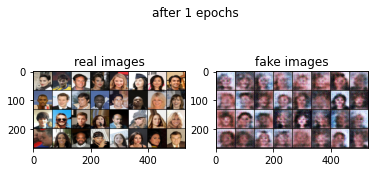

epoch:2/10 iteration:0/202599 Loss C :-1.7357220649719238 -- Loss G :198.34310913085938
epoch:2/10 iteration:100/202599 Loss C :-1.8863463401794434 -- Loss G :197.66612243652344
epoch:2/10 iteration:200/202599 Loss C :-1.964110255241394 -- Loss G :195.13319396972656
epoch:2/10 iteration:300/202599 Loss C :-1.5726441144943237 -- Loss G :193.72360229492188
epoch:2/10 iteration:400/202599 Loss C :-3.238135814666748 -- Loss G :193.16195678710938
epoch:2/10 iteration:500/202599 Loss C :-1.8379652500152588 -- Loss G :194.27581787109375
epoch:2/10 iteration:600/202599 Loss C :-3.4582741260528564 -- Loss G :186.9344024658203
epoch:2/10 iteration:700/202599 Loss C :-3.6243252754211426 -- Loss G :191.0494384765625
epoch:2/10 iteration:800/202599 Loss C :-4.274482727050781 -- Loss G :182.63526916503906
epoch:2/10 iteration:900/202599 Loss C :-3.514244794845581 -- Loss G :184.3890838623047
epoch:2/10 iteration:1000/202599 Loss C :-4.112878322601318 -- Loss G :183.26046752929688
epoch:2/10 iteratio

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

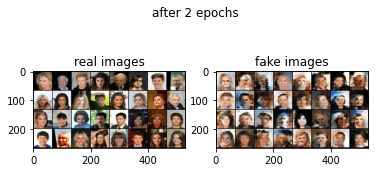

epoch:3/10 iteration:0/202599 Loss C :-4.34480619430542 -- Loss G :174.61978149414062
epoch:3/10 iteration:100/202599 Loss C :-2.9742300510406494 -- Loss G :174.82301330566406
epoch:3/10 iteration:200/202599 Loss C :-5.162817001342773 -- Loss G :176.28375244140625
epoch:3/10 iteration:300/202599 Loss C :-2.579460620880127 -- Loss G :172.26296997070312
epoch:3/10 iteration:400/202599 Loss C :-4.702548503875732 -- Loss G :164.45889282226562
epoch:3/10 iteration:500/202599 Loss C :-3.318647861480713 -- Loss G :169.94622802734375
epoch:3/10 iteration:600/202599 Loss C :-3.2114837169647217 -- Loss G :168.4310302734375
epoch:3/10 iteration:700/202599 Loss C :-4.25034236907959 -- Loss G :171.0691680908203
epoch:3/10 iteration:800/202599 Loss C :-2.999742031097412 -- Loss G :172.6978759765625
epoch:3/10 iteration:900/202599 Loss C :-2.103071689605713 -- Loss G :166.68032836914062
epoch:3/10 iteration:1000/202599 Loss C :-4.663679599761963 -- Loss G :167.16400146484375
epoch:3/10 iteration:1100

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

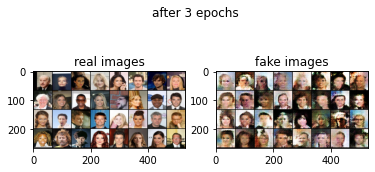

epoch:4/10 iteration:0/202599 Loss C :-1.8877214193344116 -- Loss G :164.37771606445312
epoch:4/10 iteration:100/202599 Loss C :-3.3006768226623535 -- Loss G :164.1476593017578
epoch:4/10 iteration:200/202599 Loss C :-3.384631872177124 -- Loss G :163.54180908203125
epoch:4/10 iteration:300/202599 Loss C :-3.270171642303467 -- Loss G :165.69366455078125
epoch:4/10 iteration:400/202599 Loss C :-2.829664945602417 -- Loss G :162.63882446289062
epoch:4/10 iteration:500/202599 Loss C :-3.697075605392456 -- Loss G :167.2513427734375
epoch:4/10 iteration:600/202599 Loss C :-4.374538898468018 -- Loss G :164.66998291015625
epoch:4/10 iteration:700/202599 Loss C :-3.8441171646118164 -- Loss G :162.75350952148438
epoch:4/10 iteration:800/202599 Loss C :-2.858130931854248 -- Loss G :162.2071533203125
epoch:4/10 iteration:900/202599 Loss C :-4.486086368560791 -- Loss G :159.74398803710938
epoch:4/10 iteration:1000/202599 Loss C :-4.402553558349609 -- Loss G :161.85595703125
epoch:4/10 iteration:1100

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

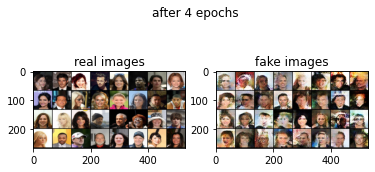

epoch:5/10 iteration:0/202599 Loss C :-2.9501399993896484 -- Loss G :164.26443481445312
epoch:5/10 iteration:100/202599 Loss C :-3.561622381210327 -- Loss G :160.68312072753906
epoch:5/10 iteration:200/202599 Loss C :-3.875798225402832 -- Loss G :159.51736450195312
epoch:5/10 iteration:300/202599 Loss C :-3.6536898612976074 -- Loss G :160.16188049316406
epoch:5/10 iteration:400/202599 Loss C :-3.662743330001831 -- Loss G :161.7061767578125
epoch:5/10 iteration:500/202599 Loss C :-3.379028797149658 -- Loss G :161.6208038330078
epoch:5/10 iteration:600/202599 Loss C :-1.965174913406372 -- Loss G :162.80026245117188
epoch:5/10 iteration:700/202599 Loss C :-2.968079090118408 -- Loss G :159.71913146972656
epoch:5/10 iteration:800/202599 Loss C :-3.2087247371673584 -- Loss G :160.1591796875
epoch:5/10 iteration:900/202599 Loss C :-2.564993143081665 -- Loss G :160.08905029296875
epoch:5/10 iteration:1000/202599 Loss C :-3.5633084774017334 -- Loss G :160.3436737060547
epoch:5/10 iteration:1100

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

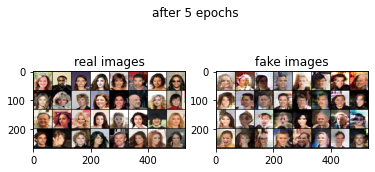

epoch:6/10 iteration:0/202599 Loss C :-1.5777113437652588 -- Loss G :153.05331420898438
epoch:6/10 iteration:100/202599 Loss C :-3.646958827972412 -- Loss G :155.88455200195312
epoch:6/10 iteration:200/202599 Loss C :-1.4032299518585205 -- Loss G :156.11819458007812
epoch:6/10 iteration:300/202599 Loss C :-2.44265079498291 -- Loss G :159.38258361816406
epoch:6/10 iteration:400/202599 Loss C :-1.5576186180114746 -- Loss G :159.45120239257812
epoch:6/10 iteration:500/202599 Loss C :-2.35801362991333 -- Loss G :156.39303588867188
epoch:6/10 iteration:600/202599 Loss C :-3.3659250736236572 -- Loss G :162.23495483398438
epoch:6/10 iteration:700/202599 Loss C :-3.226140022277832 -- Loss G :160.43528747558594
epoch:6/10 iteration:800/202599 Loss C :-2.1561644077301025 -- Loss G :155.75277709960938
epoch:6/10 iteration:900/202599 Loss C :-2.6724774837493896 -- Loss G :155.34878540039062
epoch:6/10 iteration:1000/202599 Loss C :-3.478593111038208 -- Loss G :162.00320434570312
epoch:6/10 iterati

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

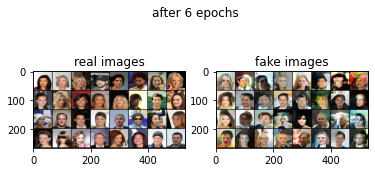

epoch:7/10 iteration:0/202599 Loss C :-2.079169750213623 -- Loss G :158.03610229492188
epoch:7/10 iteration:100/202599 Loss C :-3.214923858642578 -- Loss G :164.11595153808594
epoch:7/10 iteration:200/202599 Loss C :-2.3652408123016357 -- Loss G :159.50503540039062
epoch:7/10 iteration:300/202599 Loss C :-1.8699742555618286 -- Loss G :159.2349395751953
epoch:7/10 iteration:400/202599 Loss C :-1.8229210376739502 -- Loss G :156.96192932128906
epoch:7/10 iteration:500/202599 Loss C :-3.0297398567199707 -- Loss G :161.8912353515625
epoch:7/10 iteration:600/202599 Loss C :-2.1545135974884033 -- Loss G :154.7060546875
epoch:7/10 iteration:700/202599 Loss C :-2.623710870742798 -- Loss G :156.4007568359375
epoch:7/10 iteration:800/202599 Loss C :-1.5868090391159058 -- Loss G :159.04656982421875
epoch:7/10 iteration:900/202599 Loss C :-2.520763874053955 -- Loss G :157.22525024414062
epoch:7/10 iteration:1000/202599 Loss C :-1.4419362545013428 -- Loss G :160.06744384765625
epoch:7/10 iteration:1

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

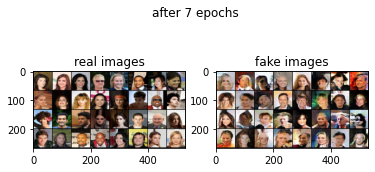

epoch:8/10 iteration:0/202599 Loss C :-1.6719211339950562 -- Loss G :158.79446411132812
epoch:8/10 iteration:100/202599 Loss C :-2.1868326663970947 -- Loss G :158.58242797851562
epoch:8/10 iteration:200/202599 Loss C :-1.0828406810760498 -- Loss G :160.5626220703125
epoch:8/10 iteration:300/202599 Loss C :-1.845810055732727 -- Loss G :156.48330688476562
epoch:8/10 iteration:400/202599 Loss C :-2.334582567214966 -- Loss G :155.6863555908203
epoch:8/10 iteration:500/202599 Loss C :-2.5504584312438965 -- Loss G :157.86158752441406
epoch:8/10 iteration:600/202599 Loss C :-2.825139284133911 -- Loss G :153.2281951904297
epoch:8/10 iteration:700/202599 Loss C :-3.077204942703247 -- Loss G :155.87921142578125
epoch:8/10 iteration:800/202599 Loss C :-2.518129348754883 -- Loss G :157.21902465820312
epoch:8/10 iteration:900/202599 Loss C :-1.6147220134735107 -- Loss G :159.0538330078125
epoch:8/10 iteration:1000/202599 Loss C :-1.6378332376480103 -- Loss G :161.84005737304688
epoch:8/10 iteration

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

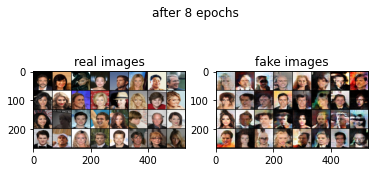

epoch:9/10 iteration:0/202599 Loss C :-1.1565839052200317 -- Loss G :146.34751892089844
epoch:9/10 iteration:100/202599 Loss C :-2.25392484664917 -- Loss G :138.81515502929688
epoch:9/10 iteration:200/202599 Loss C :0.7980920076370239 -- Loss G :126.22681427001953
epoch:9/10 iteration:300/202599 Loss C :-4.413433074951172 -- Loss G :124.76221466064453
epoch:9/10 iteration:400/202599 Loss C :-1.3408372402191162 -- Loss G :118.9236831665039
epoch:9/10 iteration:500/202599 Loss C :-2.3937246799468994 -- Loss G :105.29478454589844
epoch:9/10 iteration:600/202599 Loss C :0.30384737253189087 -- Loss G :110.07437133789062
epoch:9/10 iteration:700/202599 Loss C :-2.4256811141967773 -- Loss G :99.45611572265625
epoch:9/10 iteration:800/202599 Loss C :-1.306573748588562 -- Loss G :85.70282745361328
epoch:9/10 iteration:900/202599 Loss C :-1.321818470954895 -- Loss G :75.25871276855469
epoch:9/10 iteration:1000/202599 Loss C :0.14037173986434937 -- Loss G :78.83275604248047
epoch:9/10 iteration:1

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

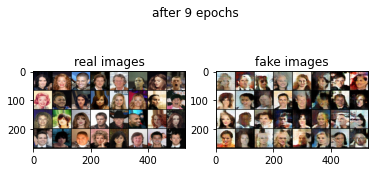

epoch:10/10 iteration:0/202599 Loss C :-2.0443153381347656 -- Loss G :47.816749572753906
epoch:10/10 iteration:100/202599 Loss C :-0.7640593647956848 -- Loss G :55.89149856567383
epoch:10/10 iteration:200/202599 Loss C :-0.9374011158943176 -- Loss G :56.69961166381836
epoch:10/10 iteration:300/202599 Loss C :-0.603408932685852 -- Loss G :49.969383239746094
epoch:10/10 iteration:400/202599 Loss C :0.9907078742980957 -- Loss G :46.91697311401367
epoch:10/10 iteration:500/202599 Loss C :0.5858145356178284 -- Loss G :35.18301773071289
epoch:10/10 iteration:600/202599 Loss C :-2.1874492168426514 -- Loss G :38.576210021972656
epoch:10/10 iteration:700/202599 Loss C :-0.06477762758731842 -- Loss G :40.291709899902344
epoch:10/10 iteration:800/202599 Loss C :-0.3833203911781311 -- Loss G :32.98188781738281
epoch:10/10 iteration:900/202599 Loss C :-0.9610210061073303 -- Loss G :42.46046447753906
epoch:10/10 iteration:1000/202599 Loss C :-1.1498112678527832 -- Loss G :53.72142028808594
epoch:10/

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

<Figure size 936x288 with 0 Axes>

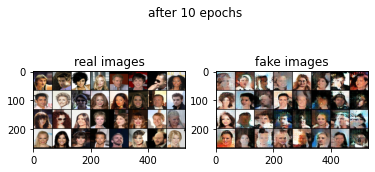

In [ ]:
C=Critic(img_channels,hidden_C).to(device)
G=Generator(noise_channels,img_channels,hidden_G).to(device)

#C=C.apply(init_weights)
#G=G.apply(init_weights)

wandb.watch(G, log='all', log_freq=10)
wandb.watch(C, log='all', log_freq=10)

opt_C=torch.optim.Adam(C.parameters(),lr=lr, betas=(0.5,0.999))
opt_G=torch.optim.Adam(G.parameters(),lr=lr, betas=(0.5,0.999))

gen_repeats=1
crit_repeats=3

noise_for_generate=torch.randn(batch_size,noise_channels,1,1).to(device)

losses_C=[]
losses_G=[]

for epoch in range(1,epochs+1):
  loss_C_epoch=[]
  loss_G_epoch=[]

  for idx,(x,_) in enumerate(data_loader):
    C.train()
    G.train()

    x=x.to(device)
    x_len=x.shape[0]

    ### Train C

    loss_C_iter=0
    for _ in range(crit_repeats):
      opt_C.zero_grad()
      z=torch.randn(x_len,noise_channels,1,1).to(device)

      real_imgs=x
      fake_imgs=G(z).detach()

      real_C_out=C(real_imgs)
      fake_C_out=C(fake_imgs)

      epsilon= torch.rand(len(x),1,1,1, device= device, requires_grad=True)
      gradient= get_gradient(C, real_imgs, fake_imgs.detach(), epsilon)
      gp= gradient_penalty(gradient)
      loss_C= get_crit_loss(fake_C_out, real_C_out, gp, c_lambda=10)

      loss_C.backward()
      opt_C.step()

      loss_C_iter+=loss_C.item()/crit_repeats

    ### Train G
    loss_G_iter=0
    for _ in range(gen_repeats):
      opt_G.zero_grad()
      z=torch.randn(x_len,noise_channels,1,1).to(device)
      fake_C_out = C(G(z))
      loss_G= get_gen_loss(fake_C_out)
      loss_G.backward()
      opt_G.step()

      loss_G_iter+=loss_G.item()/gen_repeats

    ### Return current state
    if idx%100==0:
      print(f'epoch:{epoch}/{epochs} iteration:{idx}/{len(dataset)} Loss C :{loss_C} -- Loss G :{loss_G}')
      artifact_G=wandb.Artifact("Generator_artifact", type='model', metadata={'epoch':epoch}, description=f"after {epoch} epochs")
      artifact_C=wandb.Artifact("Critic_artifact", type='model', metadata={'epoch':epoch}, description=f"after {epoch} epochs")

      save_model_as_checkpoint_wfdb(epoch=epoch, model=G, optimizer=opt_G, loss=loss_G, path='latest_model/checkpoint_G.pth', run=run, artifact=artifact_G)
      save_model_as_checkpoint_wfdb(epoch=epoch, model=C, optimizer=opt_C, loss=loss_C, path='latest_model/checkpoint_C.pth', run=run, artifact=artifact_C)


      with torch.no_grad():
        G.eval()
        generated=G(noise_for_generate).detach()
        img_grid_real=torchvision.utils.make_grid(x[:32]*0.5+0.5).permute(1,2,0).squeeze().cpu()
        img_grid_fake=torchvision.utils.make_grid(generated[:32]*0.5+0.5).permute(1,2,0).squeeze().cpu()

        plt.figure(figsize=(13,4))
        plt.subplot(1,2,1)
        plt.imshow(img_grid_real)
        plt.title('real images')
        plt.subplot(1,2,2)
        plt.imshow(img_grid_fake)
        plt.title('fake images')
        plt.suptitle(f'after {epoch} epochs')
        #wandb.log({"img": [wandb.Image(plt, caption=f"(after {epoch} epochs)")]})
        #wandb.log({f'{name} : output images': plt, 'epoch': epoch})
        wandb.log({f"{name} : output images : (after {epoch} epochs, idx : {idx})": plt})
        plt.clf()

    
    if idx==2500:
      break

    loss_G_epoch.append(loss_G_iter)
    loss_C_epoch.append(loss_C_iter)
  losses_G.append(np.mean(loss_G_epoch))
  losses_C.append(np.mean(loss_C_epoch))

  #wandb.log({'losses_G': np.mean(loss_G_epoch), 'epoch': epoch})
  #wandb.log({'losses_C': np.mean(loss_C_epoch), 'epoch': epoch})


  # plot images for a epoch
  plt.figure(figsize=(6,3))
  plt.subplot(1,2,1)
  plt.imshow(img_grid_real)
  plt.title('real images')
  plt.subplot(1,2,2)
  plt.imshow(img_grid_fake)
  plt.title('fake images')
  plt.suptitle(f'after {epoch} epochs')
  plt.show()

  # plot losses for a epoch
  plt.figure()
  plt.plot(losses_G, label = 'Gen Loss')
  plt.plot(losses_C, label= 'Critic Loss')
  plt.title(f'after {epoch} epochs')
  wandb.log({f"losses": plt})
  plt.show()
